## The Netflix data can be obtained from

https://www.kaggle.com/datasets/muhammadibrahimqasmi/netflix-datset?select=netflix.csv

About Dataset
This Dataset is About Netflix Stock prices

About Columns:

    Date: The date of the stock data.
    Open: The opening price of Google stock on that date.
    High: The highest price of Google stock on that date.
    Low: The lowest price of Google stock on that date.
    Close: The closing price of Google stock on that date.
    Adj Close: The adjusted closing price of Google stock on that date, accounting for any corporate actions such as dividends and stock splits.
    Volume: The trading volume of Google stock on that date, i.e., the number of shares traded.


## Objectives

The objectives of this notebook is to:

 - Implement LSTM and GRU to predict stock prices

In [1]:
# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tensorflow as tf
print(tf. __version__)

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Embedding,Masking,LSTM, GRU, Conv1D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler

from keras.preprocessing import sequence
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Embedding, SimpleRNN, Input
from tensorflow.keras.datasets import reuters
from keras.utils import pad_sequences


sns.set_context('notebook')
sns.set_style('white')
np.random.seed(2024)

2.15.0


In [2]:
df = pd.read_csv("netflix.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3563 entries, 0 to 3562
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3563 non-null   object 
 1   Open       3563 non-null   float64
 2   High       3563 non-null   float64
 3   Low        3563 non-null   float64
 4   Close      3563 non-null   float64
 5   Adj Close  3563 non-null   float64
 6   Volume     3563 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 195.0+ KB


In [4]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,7.931429,7.961429,7.565714,7.640000,7.640000,17239600
1,2010-01-05,7.652857,7.657143,7.258571,7.358571,7.358571,23753100
2,2010-01-06,7.361429,7.672857,7.197143,7.617143,7.617143,23290400
3,2010-01-07,7.731429,7.757143,7.462857,7.485714,7.485714,9955400
4,2010-01-08,7.498571,7.742857,7.465714,7.614286,7.614286,8180900


Text(0.5, 1.0, 'Netflix stock')

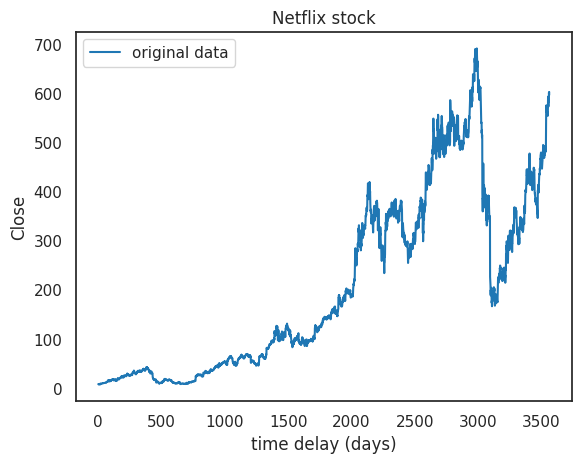

In [5]:
fig = plt.figure()
ax = plt.axes()

ax.plot(np.array(df.axes[0]), df["Adj Close"],label='original data')
ax.set_xlabel("time delay (days)")
ax.set_ylabel("Close")
ax.legend()
ax.set_title("Netflix stock")

In [6]:
def maxtrain_size(data,batch,percentage):
    '''
    maxtrain is a helper function that helps TimeseriesGenerator
    generating a train set size divisible by the batch_size.
    trainsize is a integer number divisible by batch size.
    '''
    length = len(data)
    length *= 1 - percentage
    list_range = []
    trainsize = 0
    if length%batch == 0:
        trainsize = length
    else:
        for i in range(int(length-batch),int(length)):
            xi = i%batch
            if xi == 0:
                list_range.append(i)
                #print(i)
        trainsize = max(list_range)
    return trainsize

In [7]:
def get_y_from_generator(generator):
    '''
    Get all targets y from a TimeseriesGenerator instance.
    '''
    y = None
    for i in range(len(generator)):
        batch_y = generator[i][1]
        if y is None:
            y = batch_y
        else:
            y = np.append(y, batch_y)
    y = y.reshape((-1,1))
    print(y.shape)
    return y

In [8]:
# percentage of data used for testing
test_percent = 0.2
batch_size = 3
look_back = 3

y = df[['Adj Close']]

# normalize the dataset
scaler = MinMaxScaler()
dataset = scaler.fit_transform(y)

# split into train and test sets
test_ind = maxtrain_size(y,batch_size,test_percent) # int divisible by batch_size

y_train = y.iloc[:test_ind]
y_test  = y.iloc[test_ind:]

In [9]:
scaler = MinMaxScaler()
train = scaler.fit_transform(y_train)
test = scaler.transform(y_test)

print(train.shape, test.shape)

(2847, 1) (716, 1)


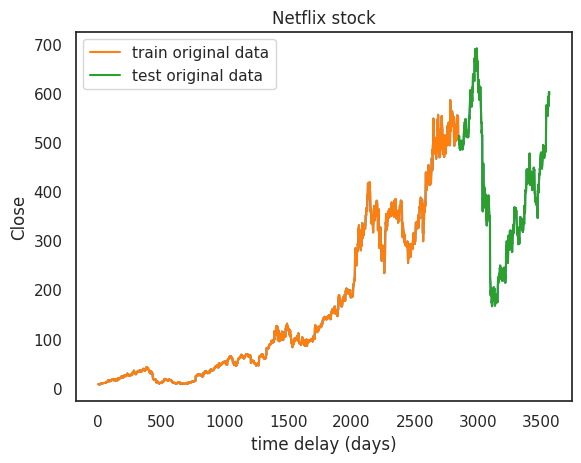

In [10]:
fig = plt.figure()
ax = plt.axes()
ax.plot(y)
ax.plot(np.array(y_train.axes[0]), y_train, label='train original data')
ax.plot(np.array(y_test.axes[0]), y_test, label='test original data')
ax.set_xlabel("time delay (days)")
ax.set_ylabel("Close")
ax.set_title("Netflix stock")
ax.legend()
plt.show()

The `look_back` is the look back length which can be tuned for different datasets and tasks. Put it simply, if `look_back` = 3, then day T's value is predicted by day T-3, T-2, and T-1's.

In [11]:
num_features = 1

train_data_gen = TimeseriesGenerator(train, train,
	length=look_back, #Length of the output sequences (in number of timesteps).
    sampling_rate=1,stride=1,
    batch_size=batch_size) # Number of timeseries samples in each batch (except maybe the last one).

test_data_gen = TimeseriesGenerator(test, test,
	length=look_back,
    sampling_rate=1,stride=1,
	batch_size=1)

print(len(train_data_gen),len(test_data_gen))
#train_data_gen.get_config()

948 713


In [12]:
#train_data_gen.__getitem__(0)

# Implement LSTM

In [13]:
model = Sequential()

model.add(LSTM(20, input_shape=(look_back, num_features)))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20)                1760      
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 1781 (6.96 KB)
Trainable params: 1781 (6.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
%time history = model.fit(train_data_gen, epochs=10 )

Epoch 1/10
948/948 [==============================] - 10s 7ms/step - loss: 0.0141 - accuracy: 7.0323e-04
Epoch 2/10
948/948 [==============================] - 7s 8ms/step - loss: 2.4074e-04 - accuracy: 7.0323e-04
Epoch 3/10
948/948 [==============================] - 6s 7ms/step - loss: 2.0845e-04 - accuracy: 7.0323e-04
Epoch 4/10
948/948 [==============================] - 3s 3ms/step - loss: 2.4906e-04 - accuracy: 7.0323e-04
Epoch 5/10
948/948 [==============================] - 3s 3ms/step - loss: 2.6319e-04 - accuracy: 7.0323e-04
Epoch 6/10
948/948 [==============================] - 4s 4ms/step - loss: 2.3711e-04 - accuracy: 7.0323e-04
Epoch 7/10
948/948 [==============================] - 4s 4ms/step - loss: 2.1299e-04 - accuracy: 7.0323e-04
Epoch 8/10
948/948 [==============================] - 4s 5ms/step - loss: 2.2616e-04 - accuracy: 7.0323e-04
Epoch 9/10
948/948 [==============================] - 4s 4ms/step - loss: 2.2407e-04 - accuracy: 7.0323e-04
Epoch 10/10
948/948 [==========

In [15]:
score = model.evaluate(test_data_gen)
trainPredict = model.predict(train_data_gen)
testPredict = model.predict(test_data_gen)

score[0]

713/713 [==============================] - 1s 2ms/step


0.0007218498503789306

In [16]:
# invert predictions, scale values back to real index/price range.
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

In [17]:
print(trainPredict.shape, testPredict.shape, trainPredict.shape[0] + testPredict.shape[0])

(2844, 1) (713, 1) 3557


In [18]:
from sklearn.metrics import mean_squared_error

# extract y_train and y_test from train_data_gen and test_data_gen
y_tr = get_y_from_generator(train_data_gen)
y_tst = get_y_from_generator(test_data_gen)

trainScore = math.sqrt(mean_squared_error(y_tr[:,0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_tst[:, 0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

(2844, 1)
(713, 1)
Train Score: 222.91 RMSE
Test Score: 426.68 RMSE


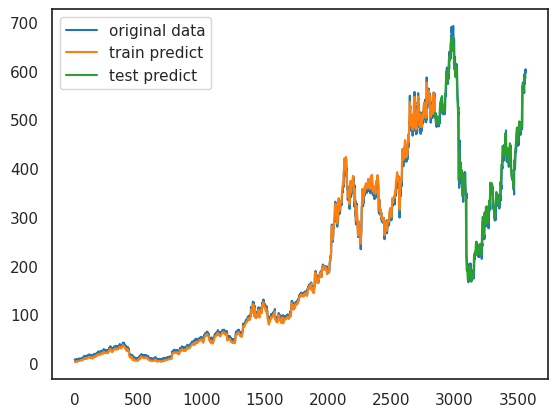

In [19]:
fig = plt.figure()

plt.plot(y, label='original data')
plt.plot(range(trainPredict.shape[0]),trainPredict, label='train predict')
plt.plot(range(trainPredict.shape[0],trainPredict.shape[0] + testPredict.shape[0]), testPredict, label='test predict')
plt.legend()

## Implement GRU and compare its performance against LSTM

In [20]:
model2 = Sequential()

model2.add(GRU(20, input_shape=(look_back, num_features)))

model2.add(Dense(1))

model2.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 20)                1380      
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 1401 (5.47 KB)
Trainable params: 1401 (5.47 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
%time history = model2.fit(train_data_gen, epochs=10 )

Epoch 1/10
948/948 [==============================] - 5s 4ms/step - loss: 0.0079 - accuracy: 3.5162e-04
Epoch 2/10
948/948 [==============================] - 4s 4ms/step - loss: 1.8282e-04 - accuracy: 7.0323e-04
Epoch 3/10
948/948 [==============================] - 4s 5ms/step - loss: 2.2769e-04 - accuracy: 7.0323e-04
Epoch 4/10
948/948 [==============================] - 5s 5ms/step - loss: 2.1709e-04 - accuracy: 7.0323e-04
Epoch 5/10
948/948 [==============================] - 3s 3ms/step - loss: 2.1492e-04 - accuracy: 7.0323e-04
Epoch 6/10
948/948 [==============================] - 3s 3ms/step - loss: 2.0700e-04 - accuracy: 7.0323e-04
Epoch 7/10
948/948 [==============================] - 4s 4ms/step - loss: 1.9552e-04 - accuracy: 7.0323e-04
Epoch 8/10
948/948 [==============================] - 3s 3ms/step - loss: 1.8477e-04 - accuracy: 7.0323e-04
Epoch 9/10
948/948 [==============================] - 3s 3ms/step - loss: 1.8701e-04 - accuracy: 7.0323e-04
Epoch 10/10
948/948 [===========

In [22]:
score2 = model2.evaluate(test_data_gen)
trainPredict = model2.predict(train_data_gen)
testPredict = model2.predict(test_data_gen)

score2[0]

713/713 [==============================] - 1s 2ms/step


0.0005430091987363994

In [23]:
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

In [24]:
# extract y_train and y_test from train_data_gen and test_data_gen
y_tr = get_y_from_generator(train_data_gen)
y_tst = get_y_from_generator(test_data_gen)

trainScore = math.sqrt(mean_squared_error(y_tr[:,0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_tst[:, 0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

(2844, 1)
(713, 1)
Train Score: 223.04 RMSE
Test Score: 427.14 RMSE


In brief, while GRU is less computationally demanding and runs faster, it has shown performance comparable to LSTM.

Below is a trick to save a notebook as PDF

In [ ]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [35]:
!cp drive/MyDrive/ColabNotebooks/Netflix.ipynb ./

In [38]:
!jupyter nbconvert --to PDF "Netflix.ipynb"

[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 170910 bytes to Netflix.pdf
